In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from scipy.stats import zscore
import warnings

warnings.filterwarnings('ignore')

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

engine.dispose()

In [4]:
years = df["YEAR"].unique()

for col in list(df.columns[3:]):
    for year in years:
        null_index = df[(df["YEAR"] == year) & (df[col].isnull())][col].index
        df.loc[null_index, [col]] = df[df["YEAR"] == year][col].mean()

In [5]:
for col in list(df.columns[3:]):
    for year in years:
        null_index = df[(df["YEAR"] == year) & (df[col].isnull())][col].index
        df.loc[null_index, [col]] = df.interpolate(inplace=True)

In [6]:
zscores = zscore(df.TOTAL_REVENUE)
greater = list(np.where(zscores > 4)[0])
for row in greater:
    df.loc[row, ['TOTAL_REVENUE']] = df['TOTAL_REVENUE'].mean()

In [7]:
zscores = zscore(df.TOTAL_EXPENDITURE)
greater = list(np.where(zscores > 4)[0])
for row in greater:
    df.loc[row, ['TOTAL_EXPENDITURE']] = df['TOTAL_EXPENDITURE'].mean()

Create a new score variable from the weighted averages of all score variables in the datasets. 

In [8]:
grd4_weight = df.GRADES_4_G / (df.GRADES_4_G + df.GRADES_8_G)
grd8_weight = df.GRADES_8_G / (df.GRADES_4_G + df.GRADES_8_G)

df['score'] = (grd4_weight * (df.AVG_MATH_4_SCORE + df.AVG_READING_4_SCORE) / 2 +
               grd8_weight * (df.AVG_MATH_8_SCORE + df.AVG_READING_8_SCORE) / 2)

What are the correlations between this newly created score variable and the expenditure types?  Which 1 of the expenditure types is more correlated than the others?

In [9]:
df[['TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
    'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'score']].corr()

,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,score
TOTAL_EXPENDITURE,1.000000,0.711437,0.737269,0.689833,0.675323,0.181232
INSTRUCTION_EXPENDITURE,0.711437,1.000000,0.977016,0.909006,0.895642,0.159620
SUPPORT_SERVICES_EXPENDITURE,0.737269,0.977016,1.000000,0.952209,0.917217,0.170274
OTHER_EXPENDITURE,0.689833,0.909006,0.952209,1.000000,0.920362,0.121376
CAPITAL_OUTLAY_EXPENDITURE,0.675323,0.895642,0.917217,0.920362,1.000000,0.105584
score,0.181232,0.159620,0.170274,0.121376,0.105584,1.000000


TOTAL_EXPENDITURE is the most correlated at .18

Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [1]:
df2 = df.dropna()
df2 = df2.drop(['PRIMARY_KEY', 'STATE'], axis = 1)

NameError: name 'df' is not defined

In [11]:
df2 = df.dropna()
df2 = df2.drop(['PRIMARY_KEY'], axis = 1)
df2 = pd.get_dummies(df2)
df2.head()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,STATE_U.S._VIRGIN_ISLANDS,STATE_UTAH,STATE_VERMONT,STATE_VI,STATE_VIRGINIA,STATE_VIRGIN_ISLANDS,STATE_WASHINGTON,STATE_WEST_VIRGINIA,STATE_WISCONSIN,STATE_WYOMING
36,2001,89711.0000,804297.0,69172.0,403021.0,332104.0,787949.0,426072.0,254937.0,24913.0000,...,0,0,0,0,0,0,0,0,0,1
37,1992,129586.3125,2396705.0,211627.0,1470516.0,714562.0,2515272.0,1283577.0,779828.0,38182.3125,...,0,0,0,0,0,0,0,0,0,0
38,1992,169461.6250,2773959.0,163544.0,788309.0,1822106.0,2898210.0,1556770.0,967075.0,51451.6250,...,0,0,0,0,0,0,0,0,0,0
39,1992,209336.9375,11257252.0,658139.0,4227323.0,6371790.0,11539253.0,6075381.0,3329224.0,64720.9375,...,0,0,0,0,0,0,0,0,0,0
40,1992,249212.2500,883073.0,43545.0,329810.0,509718.0,863404.0,556787.0,265279.0,77990.2500,...,0,0,0,0,0,0,0,0,0,0


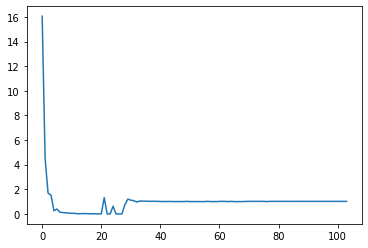

[1.60517399e+01 4.46294839e+00 1.68520736e+00 1.52195071e+00
 2.49379032e-01 3.97699508e-01 1.35544252e-01 1.08056360e-01
 8.47193081e-02 6.73798881e-02 5.08626609e-02 4.89257831e-02
 1.07919623e-02 1.91741924e-02 2.87877061e-02 2.49109199e-02
 8.18865930e-03 1.66539628e-02 4.92254261e-03 2.96430650e-03
 2.64409337e-03 1.32034838e+00 7.18403063e-04 1.20962908e-03
 6.23564314e-01 2.17940136e-04 7.12568126e-05 2.21976880e-15
 7.52948283e-01 1.20667360e+00 1.11533436e+00 1.07199480e+00
 9.67444230e-01 1.04413167e+00 1.03714381e+00 1.03157791e+00
 1.02756545e+00 1.02486730e+00 1.02381700e+00 1.02287227e+00
 1.01000376e+00 1.00654591e+00 1.00599261e+00 1.01328032e+00
 1.00412660e+00 1.00379544e+00 1.00302524e+00 1.00346536e+00
 1.00265610e+00 1.02091738e+00 1.00227658e+00 1.00213807e+00
 1.00209150e+00 1.00185029e+00 1.00192456e+00 1.00164490e+00
 1.02013835e+00 1.00151739e+00 1.00145431e+00 1.00142451e+00
 1.01628085e+00 1.01984174e+00 1.01696656e+00 1.00139455e+00
 1.01937230e+00 1.001402

In [12]:
X = StandardScaler().fit_transform(df2)
Cx = np.cov(X.T)
eigval, eigvec = np.linalg.eig(Cx)
plt.plot(eigval)
plt.show()
print(eigval)

In [13]:
pca = PCA(n_components=5)
pca.fit_transform(X)
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.15423765 0.04288349 0.01616448 0.0145715  0.01213777]


In [15]:
X = df2[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
    'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']]
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=4)
pca.fit_transform(X)
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94649679 0.03049925 0.01949313 0.00351083]


95%

What is the correlation between the overall score variable and the 1st principal component?
If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

In [16]:
pca = PCA(n_components = 1)
df2['pca1'] = pca.fit_transform(X)
df2[['score', 'pca1']].corr()

,score,pca1
score,1.000000,0.139004
pca1,0.139004,1.000000


In [18]:
df2[["score", "pca1", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

,score,pca1,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
score,1.000000,0.139004,0.177573,0.155126,0.166030,0.121376,0.097400
pca1,0.139004,1.000000,0.720945,0.971949,0.988631,0.971804,0.958910
TOTAL_EXPENDITURE,0.177573,0.720945,1.000000,0.707921,0.733902,0.689833,0.673143
INSTRUCTION_EXPENDITURE,0.155126,0.971949,0.707921,1.000000,0.976879,0.909006,0.895485
SUPPORT_SERVICES_EXPENDITURE,0.166030,0.988631,0.733902,0.976879,1.000000,0.952209,0.917160
OTHER_EXPENDITURE,0.121376,0.971804,0.689833,0.909006,0.952209,1.000000,0.920362
CAPITAL_OUTLAY_EXPENDITURE,0.097400,0.958910,0.673143,0.895485,0.917160,0.920362,1.000000


Total expenditure is probably a better feature to use. It is more correlated with score.